In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
from fastai.text import *

In [3]:
bs=64

In [4]:
path = untar_data(URLs.HUMAN_NUMBERS)
path.ls()

[PosixPath('/storage/human_numbers/train.txt'),
 PosixPath('/storage/human_numbers/valid.txt'),
 PosixPath('/storage/human_numbers/models')]

In [5]:
def readnums(d): return [', '.join(o.strip() for o in open(path/d).readlines())]

In [6]:
train_txt = readnums('train.txt'); train_txt[0][:80]

'one, two, three, four, five, six, seven, eight, nine, ten, eleven, twelve, thirt'

In [7]:
valid_txt = readnums('valid.txt'); valid_txt[0][-80:]

' nine thousand nine hundred ninety eight, nine thousand nine hundred ninety nine'

In [8]:
train = TextList(train_txt, path=path)
valid = TextList(valid_txt, path=path)

src = ItemLists(path=path, train=train, valid=valid).label_for_lm()
data = src.databunch(bs=bs)

In [9]:
data.show_batch()

idx,text
0,"thirty one , thirty two , thirty three , thirty four , thirty five , thirty six , thirty seven , thirty eight , thirty nine , forty , forty one , forty two , forty three , forty four , forty five , forty six , forty seven , forty eight , forty nine , fifty , fifty one , fifty two , fifty three , fifty four ,"
1,"twenty six , two hundred twenty seven , two hundred twenty eight , two hundred twenty nine , two hundred thirty , two hundred thirty one , two hundred thirty two , two hundred thirty three , two hundred thirty four , two hundred thirty five , two hundred thirty six , two hundred thirty seven , two hundred thirty eight , two hundred thirty nine , two hundred forty"
2,", three hundred ninety , three hundred ninety one , three hundred ninety two , three hundred ninety three , three hundred ninety four , three hundred ninety five , three hundred ninety six , three hundred ninety seven , three hundred ninety eight , three hundred ninety nine , four hundred , four hundred one , four hundred two , four hundred three , four hundred four , four"
3,"fifty seven , five hundred fifty eight , five hundred fifty nine , five hundred sixty , five hundred sixty one , five hundred sixty two , five hundred sixty three , five hundred sixty four , five hundred sixty five , five hundred sixty six , five hundred sixty seven , five hundred sixty eight , five hundred sixty nine , five hundred seventy , five hundred seventy one"
4,", seven hundred twenty five , seven hundred twenty six , seven hundred twenty seven , seven hundred twenty eight , seven hundred twenty nine , seven hundred thirty , seven hundred thirty one , seven hundred thirty two , seven hundred thirty three , seven hundred thirty four , seven hundred thirty five , seven hundred thirty six , seven hundred thirty seven , seven hundred thirty eight ,"


In [10]:
# Length of validation set
len(data.valid_ds[0][0].data)

13017

In [11]:
#Validation set size and bptt(Backpropagation through time)
data.bptt, len(data.valid_dl)

(70, 3)

So the data is loaded into and the labels are offset by one as we are feeding into the model one, two -> predict three (label)

In [12]:
data.show_batch(ds_type=DatasetType.Valid)

idx,text
0,"xxbos eight thousand one , eight thousand two , eight thousand three , eight thousand four , eight thousand five , eight thousand six , eight thousand seven , eight thousand eight , eight thousand nine , eight thousand ten , eight thousand eleven , eight thousand twelve , eight thousand thirteen , eight thousand fourteen , eight thousand fifteen , eight thousand sixteen , eight thousand seventeen , eight"
1,", eight thousand forty six , eight thousand forty seven , eight thousand forty eight , eight thousand forty nine , eight thousand fifty , eight thousand fifty one , eight thousand fifty two , eight thousand fifty three , eight thousand fifty four , eight thousand fifty five , eight thousand fifty six , eight thousand fifty seven , eight thousand fifty eight , eight thousand fifty nine ,"
2,"thousand eighty seven , eight thousand eighty eight , eight thousand eighty nine , eight thousand ninety , eight thousand ninety one , eight thousand ninety two , eight thousand ninety three , eight thousand ninety four , eight thousand ninety five , eight thousand ninety six , eight thousand ninety seven , eight thousand ninety eight , eight thousand ninety nine , eight thousand one hundred , eight thousand"
3,"one hundred twenty three , eight thousand one hundred twenty four , eight thousand one hundred twenty five , eight thousand one hundred twenty six , eight thousand one hundred twenty seven , eight thousand one hundred twenty eight , eight thousand one hundred twenty nine , eight thousand one hundred thirty , eight thousand one hundred thirty one , eight thousand one hundred thirty two , eight thousand one"
4,"two , eight thousand one hundred fifty three , eight thousand one hundred fifty four , eight thousand one hundred fifty five , eight thousand one hundred fifty six , eight thousand one hundred fifty seven , eight thousand one hundred fifty eight , eight thousand one hundred fifty nine , eight thousand one hundred sixty , eight thousand one hundred sixty one , eight thousand one hundred sixty two"


In [13]:
data.show_batch(ds_type=DatasetType.Train)

idx,text
0,"fifty five , fifty six , fifty seven , fifty eight , fifty nine , sixty , sixty one , sixty two , sixty three , sixty four , sixty five , sixty six , sixty seven , sixty eight , sixty nine , seventy , seventy one , seventy two , seventy three , seventy four , seventy five , seventy six , seventy seven , seventy eight ,"
1,", two hundred forty one , two hundred forty two , two hundred forty three , two hundred forty four , two hundred forty five , two hundred forty six , two hundred forty seven , two hundred forty eight , two hundred forty nine , two hundred fifty , two hundred fifty one , two hundred fifty two , two hundred fifty three , two hundred fifty four ,"
2,"hundred five , four hundred six , four hundred seven , four hundred eight , four hundred nine , four hundred ten , four hundred eleven , four hundred twelve , four hundred thirteen , four hundred fourteen , four hundred fifteen , four hundred sixteen , four hundred seventeen , four hundred eighteen , four hundred nineteen , four hundred twenty , four hundred twenty one , four hundred"
3,", five hundred seventy two , five hundred seventy three , five hundred seventy four , five hundred seventy five , five hundred seventy six , five hundred seventy seven , five hundred seventy eight , five hundred seventy nine , five hundred eighty , five hundred eighty one , five hundred eighty two , five hundred eighty three , five hundred eighty four , five hundred eighty five ,"
4,"seven hundred thirty nine , seven hundred forty , seven hundred forty one , seven hundred forty two , seven hundred forty three , seven hundred forty four , seven hundred forty five , seven hundred forty six , seven hundred forty seven , seven hundred forty eight , seven hundred forty nine , seven hundred fifty , seven hundred fifty one , seven hundred fifty two , seven hundred"


In [14]:
v = data.valid_ds.vocab

## Loss Function and accuracy Function

In [15]:
def loss4(input,target): return F.cross_entropy(input, target[:,-1])
def acc4 (input,target): return accuracy(input, target[:,-1])

## Single Fully Connected

#### Input -> Hidden -> softmax output
This model takes 2 values and predicts the 3rd
THis is the bptt (Backpropagation through time used to training rnns ) length

In [16]:
data = src.databunch(bs=bs, bptt=3)

In [17]:
data.show_batch()

idx,text
0,"two , three"
1,two hundred eleven
2,hundred seventy six
3,", five hundred"
4,seven hundred nine


In [18]:
x,y = data.one_batch()
x.shape,y.shape

(torch.Size([64, 3]), torch.Size([64, 3]))

In [19]:
nv = len(v.itos); nv

40

In [20]:
nh=64

In [21]:
class Model0(nn.Module):
    def __init__(self):
        super().__init__()
        self.i_h = nn.Embedding(nv,nh)  # green arrow
        self.h_h = nn.Linear(nh,nh)     # brown arrow
        self.h_o = nn.Linear(nh,nv)     # blue arrow
        self.bn = nn.BatchNorm1d(nh)
        
    def forward(self, x):
        h = self.bn(F.relu(self.h_h(self.i_h(x[:,0]))))
        if x.shape[1]>1:
            h = h + self.i_h(x[:,1])
            h = self.bn(F.relu(self.h_h(h)))
        if x.shape[1]>2:
            h = h + self.i_h(x[:,2])
            h = self.bn(F.relu(self.h_h(h)))
        return self.h_o(h)

In [22]:
learn = Learner(data, Model0(), loss_func=loss4, metrics=acc4)

epoch,train_loss,valid_loss,acc4,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


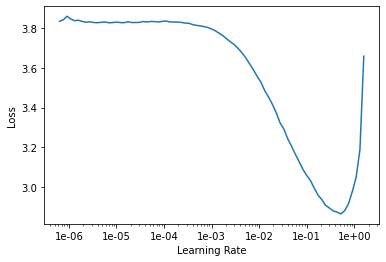

In [23]:
learn.lr_find()
learn.recorder.plot()

In [24]:
learn.fit_one_cycle(15, 1e-4)

epoch,train_loss,valid_loss,acc4,time
0,3.720148,3.718200,0.020221,00:01
1,3.390219,3.392191,0.160846,00:01
2,2.803180,2.838015,0.430607,00:01
3,2.246569,2.318076,0.455423,00:01
4,1.916301,2.054147,0.465074,00:01
5,1.738525,1.944674,0.470818,00:01
6,1.643034,1.899346,0.470588,00:01
7,1.589637,1.880786,0.470818,00:01
8,1.558306,1.874484,0.471967,00:01
9,1.539093,1.873988,0.471737,00:01


## Same thing with a loop
So this is the same model as before but with a loop function so we can predict ever N + 1 of any length

In [35]:
data = src.databunch(bs=bs, bptt=20)

In [36]:
class Model1(nn.Module):
    def __init__(self):
        super().__init__()
        self.i_h = nn.Embedding(nv,nh)  # green arrow
        self.h_h = nn.Linear(nh,nh)     # brown arrow
        self.h_o = nn.Linear(nh,nv)     # blue arrow
        self.bn = nn.BatchNorm1d(nh)
        
    def forward(self, x):
        h = torch.zeros(x.shape[0], nh).to(device=x.device)
        for i in range(x.shape[1]):
            h = h + self.i_h(x[:,i])
            h = self.bn(F.relu(self.h_h(h)))
        return self.h_o(h)


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


Model1
Layer (type)         Output Shape         Param #    Trainable 
Embedding            [64]                 2,560      True      
______________________________________________________________________
Linear               [64]                 4,160      True      
______________________________________________________________________
Linear               [40]                 2,600      True      
______________________________________________________________________
BatchNorm1d          [64]                 128        True      
______________________________________________________________________

Total params: 9,448
Total trainable params: 9,448
Total non-trainable params: 0
Optimized with 'torch.optim.adam.Adam', betas=(0.9, 0.99)
Using true weight decay as discussed in https://www.fast.ai/2018/07/02/adam-weight-decay/ 
Loss function : function
Callbacks functions applied 

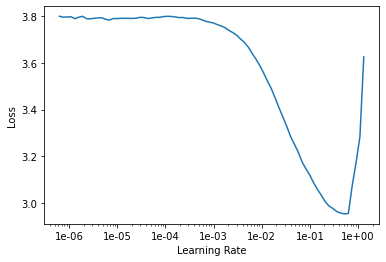

In [40]:
learn = Learner(data, Model1(), loss_func=loss4, metrics=acc4)
learn.lr_find()
learn.recorder.plot()
learn.summary()

In [38]:
learn.fit_one_cycle(10, 1e-3)

epoch,train_loss,valid_loss,acc4,time
0,3.803755,3.804792,0.028409,00:00
1,3.509575,3.202263,0.257102,00:00
2,2.908714,2.419760,0.383523,00:00
3,2.342166,2.124172,0.399148,00:00
4,1.973905,2.038646,0.401989,00:00
5,1.746911,2.005366,0.409091,00:00
6,1.601138,1.987903,0.419034,00:00
7,1.504844,1.981668,0.424716,00:00
8,1.444133,1.979616,0.428977,00:00
9,1.411514,1.979252,0.428977,00:00


## Multi fully connected model
This is doing a prediction after every word this is worse as it does not have memoery of past inputs 
It resets its state to zero after every bptt sequence 

h = torch.zeros(x.shape[0], nh).to(device=x.device) zeroing the state after every sequence

In [41]:
data = src.databunch(bs=bs, bptt=20)

In [42]:
x,y = data.one_batch()
x.shape,y.shape

(torch.Size([64, 20]), torch.Size([64, 20]))

In [43]:
class Model2(nn.Module):
    def __init__(self):
        super().__init__()
        self.i_h = nn.Embedding(nv,nh)
        self.h_h = nn.Linear(nh,nh)
        self.h_o = nn.Linear(nh,nv)
        self.bn = nn.BatchNorm1d(nh)
        
    def forward(self, x):
        h = torch.zeros(x.shape[0], nh).to(device=x.device)
        res = []
        for i in range(x.shape[1]):
            h = h + self.i_h(x[:,i])
            h = F.relu(self.h_h(h))
            res.append(self.h_o(self.bn(h)))
        return torch.stack(res, dim=1)

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


Model2
Layer (type)         Output Shape         Param #    Trainable 
Embedding            [64]                 2,560      True      
______________________________________________________________________
Linear               [64]                 4,160      True      
______________________________________________________________________
Linear               [40]                 2,600      True      
______________________________________________________________________
BatchNorm1d          [64]                 128        True      
______________________________________________________________________

Total params: 9,448
Total trainable params: 9,448
Total non-trainable params: 0
Optimized with 'torch.optim.adam.Adam', betas=(0.9, 0.99)
Using true weight decay as discussed in https://www.fast.ai/2018/07/02/adam-weight-decay/ 
Loss function : FlattenedLoss
Callbacks functions applied 

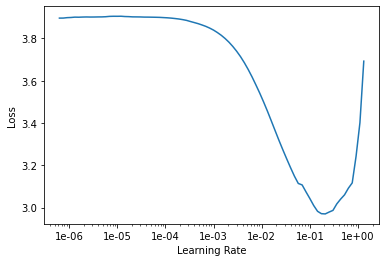

In [44]:
learn = Learner(data, Model2(), metrics=accuracy)
learn.lr_find()
learn.recorder.plot()
learn.summary()

In [45]:
learn.fit_one_cycle(10, 1e-4, pct_start=0.1)

epoch,train_loss,valid_loss,accuracy,time
0,3.852691,3.992606,0.041051,00:00
1,3.671709,3.800466,0.095028,00:00
2,3.456405,3.608863,0.178551,00:00
3,3.242950,3.435471,0.210582,00:00
4,3.053265,3.296847,0.221591,00:00
5,2.898087,3.194328,0.245384,00:00
6,2.781452,3.128329,0.257884,00:00
7,2.701969,3.092837,0.268892,00:00
8,2.653875,3.079326,0.271307,00:00
9,2.628940,3.077323,0.271449,00:00


## Maintain state
So this matains memory of previous states and appends the state to self self.h = h.detach()

In [47]:
class Model3(nn.Module):
    def __init__(self):
        super().__init__()
        self.i_h = nn.Embedding(nv,nh)
        self.h_h = nn.Linear(nh,nh)
        self.h_o = nn.Linear(nh,nv)
        self.bn = nn.BatchNorm1d(nh)
        self.h = torch.zeros(bs, nh).cuda()
        
    def forward(self, x):
        res = []
        h = self.h
        for i in range(x.shape[1]):
            h = h + self.i_h(x[:,i])
            h = F.relu(self.h_h(h))
            res.append(self.bn(h))
        self.h = h.detach()
        res = torch.stack(res, dim=1)
        res = self.h_o(res)
        return res

In [48]:
learn = Learner(data, Model3(), metrics=accuracy)
learn.summary()

Model3
Layer (type)         Output Shape         Param #    Trainable 
Embedding            [64]                 2,560      True      
______________________________________________________________________
Linear               [64]                 4,160      True      
______________________________________________________________________
Linear               [20, 40]             2,600      True      
______________________________________________________________________
BatchNorm1d          [64]                 128        True      
______________________________________________________________________

Total params: 9,448
Total trainable params: 9,448
Total non-trainable params: 0
Optimized with 'torch.optim.adam.Adam', betas=(0.9, 0.99)
Using true weight decay as discussed in https://www.fast.ai/2018/07/02/adam-weight-decay/ 
Loss function : FlattenedLoss
Callbacks functions applied 

In [49]:
learn.fit_one_cycle(20, 3e-3)

epoch,train_loss,valid_loss,accuracy,time
0,3.648355,3.512743,0.063778,00:00
1,3.144492,2.760661,0.448793,00:00
2,2.389844,2.078175,0.467898,00:00
3,1.897126,2.047578,0.316761,00:00
4,1.660285,2.106767,0.318182,00:00
5,1.538983,2.124004,0.336790,00:00
6,1.395497,1.867360,0.421946,00:00
7,1.214965,1.891233,0.430753,00:00
8,1.063864,1.820508,0.513281,00:00
9,0.916723,1.883797,0.434020,00:00


## nn.RNN
This creates a new rnn at each point res,h = self.rnn(self.i_h(x), self.h) this is the creation of a new rnn
THis creates a massive network, and is not very good for traning.
We have to use a GRU(a mini nural Net) or LSTM

In [54]:
from IPython.display import Image
from IPython.core.display import HTML 
Image(url= "https://raw.githubusercontent.com/hiromis/notes/master/lesson7/55.png", width=500, height=500)

In [56]:
class Model4(nn.Module):
    def __init__(self):
        super().__init__()
        self.i_h = nn.Embedding(nv,nh)
        self.rnn = nn.RNN(nh,nh, batch_first=True)
        self.h_o = nn.Linear(nh,nv)
        self.bn = BatchNorm1dFlat(nh)
        self.h = torch.zeros(1, bs, nh).cuda()
        
    def forward(self, x):
        res,h = self.rnn(self.i_h(x), self.h)
        self.h = h.detach()
        return self.h_o(self.bn(res))

In [57]:
learn = Learner(data, Model4(), metrics=accuracy)

In [58]:
learn.fit_one_cycle(20, 3e-3)

epoch,train_loss,valid_loss,accuracy,time
0,3.460955,3.104403,0.344389,00:00
1,2.754861,2.238148,0.466051,00:00
2,2.118627,2.088300,0.316193,00:00
3,1.764322,2.121329,0.317472,00:00
4,1.578629,1.847081,0.469744,00:00
5,1.416817,1.732539,0.465980,00:00
6,1.217867,1.577629,0.509588,00:00
7,1.019388,1.465621,0.543963,00:00
8,0.854339,1.427749,0.569886,00:00
9,0.716725,1.379399,0.571946,00:00
